# Butterfly Factorization

Following the paper "[An algorithm for the rapid evaluation 
of special function transforms](https://doi.org/10.1016/j.acha.2009.08.005)", by Michael O’Neil, Franco Woolfe, Vladimir Rokhlin.

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.linalg.interpolative as sli
import matplotlib.pyplot as plt
import scipy.special as sps
import matplotlib.pyplot as plt

# Part 1: Checking Kernel Ranks

We started with the claim that the numerical rank of the kernel $e^{ixt}$ for $x\in[0,X]$ and $t\in[0,T]$ depends only on the product $XT$:

In [17]:
Xfacs = np.linspace(1/2, 2, 30)
Tfacs = 1/Xfacs

# Change me
scale = np.pi  
resolution = 30

for Xfac, Tfac in zip(Xfacs, Tfacs):
    x, t = np.mgrid[0:Xfac*scale:resolution * 1j, 0:Tfac*scale:resolution * 1j]
    mat = np.exp(1j*x*t)
    
    _, sigma, _ = la.svd(mat)
    print(f"{Xfac:.2f} {Tfac:.2f}\t", np.sum(sigma > 1e-7))

0.50 2.00	 11
0.55 1.81	 11
0.60 1.66	 11
0.66 1.53	 11
0.71 1.41	 11
0.76 1.32	 11
0.81 1.23	 11
0.86 1.16	 11
0.91 1.09	 11
0.97 1.04	 11
1.02 0.98	 11
1.07 0.94	 11
1.12 0.89	 11
1.17 0.85	 11
1.22 0.82	 11
1.28 0.78	 11
1.33 0.75	 11
1.38 0.72	 11
1.43 0.70	 11
1.48 0.67	 11
1.53 0.65	 11
1.59 0.63	 11
1.64 0.61	 11
1.69 0.59	 11
1.74 0.57	 11
1.79 0.56	 11
1.84 0.54	 11
1.90 0.53	 11
1.95 0.51	 11
2.00 0.50	 11


# Part 2: The Butterfly Factorization

## Some Test Matrices

### A Matrix for the Discrete Fourier Transform

In [27]:
nlevels = 9
n = 2**(nlevels + 2)

In [34]:
def make_dft(n, power):
    omega = np.exp(2*np.pi*1j/n)

    ns = np.arange(n)
    exponents = ns.reshape(-1, 1) * ns
    
    return omega**(power*exponents)

dft = make_dft(n, power=1)
idft = make_dft(n, power=-1)

In [35]:
la.norm(np.abs(idft @ dft) - n*np.eye(n))

1.0665713346973323e-07

Verify the FFT property:

7.629497034145061e-11


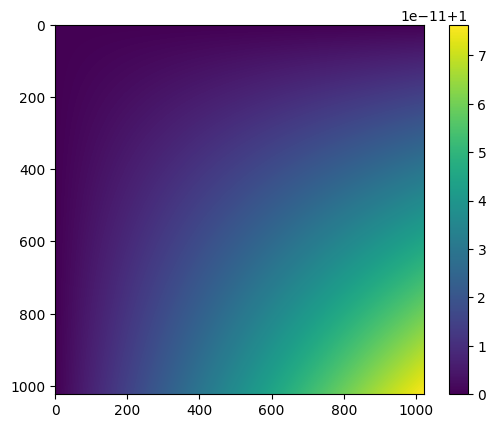

In [12]:
quotient = dft[::2, :n//2] / make_dft(n//2, power=1)
plt.imshow(quotient.real)
plt.colorbar()
print(np.max(np.abs(quotient - 1)))

### Chebyshev Transform

In [38]:
k = n-1

i = np.arange(0, k+1)
x = np.linspace(-1, 1, 3000)

nodes = np.cos(i/k*np.pi)

i = np.arange(n, dtype=np.float64)
nodes = np.cos((2*(i+1)-1)/(2*n)*np.pi)
chebyshev_vdm = np.cos(i*np.arccos(nodes.reshape(-1, 1)))

In [39]:
(chebyshev_vdm.T @ chebyshev_vdm).round(2)

array([[2048.,    0.,   -0., ...,    0.,    0.,   -0.],
       [   0., 1024.,    0., ...,    0.,    0.,    0.],
       [  -0.,    0., 1024., ...,    0.,    0.,   -0.],
       ...,
       [   0.,    0.,    0., ..., 1024.,    0.,   -0.],
       [   0.,    0.,    0., ...,    0., 1024.,    0.],
       [  -0.,    0.,   -0., ...,   -0.,    0., 1024.]])

### A Random Matrix

In [40]:
randmat = np.random.randn(n, n)

## A Matrix Slicing Helper

In [144]:
class Level:
    def __init__(self, level, nlevels, n=None):
        self.level = level
        self.nlevels = nlevels
        
        if level > nlevels:
            raise ValueError("level too large")
            
        if n is None:
            n = 2**nlevels
        self.n = n
        
    @property
    def nblock_rows(self):
        return 2**self.level
        
    @property
    def block_nrows(self):
        return self.n//self.nblock_rows

    @property
    def nblock_cols(self):
        return 2**(self.nlevels-self.level)
        
    @property
    def block_ncols(self):
        return self.n//self.nblock_cols
    
    def matview(self, bi, bj, mat):
        br = self.block_nrows
        bc = self.block_ncols
        return mat[br*bi:br*(bi+1), bc*bj:bc*(bj+1)]
    
    def rowview(self, bi, vec):
        br = self.block_nrows
        return vec[br*bi:br*(bi+1)]
    
    def colview(self, bj, vec):
        bc = self.block_ncols
        return vec[bc*bj:bc*(bj+1)]

In [145]:
Level(0, nlevels, 256).matview(0, 0, dft).shape

(256, 0)

## Rank-Revealing Factorization

In [146]:
epsilon = 1e-10

In [147]:
# ID

def id_decomp(A):
    k, idx, proj = sli.interp_decomp(A, epsilon)
    sort_idx = np.argsort(idx)
    B = A[:,idx[:k]]
    P = np.hstack([np.eye(k), proj])[:,np.argsort(idx)]
    return B, P

In [148]:
# Rank-Revealing Truncated QR

def qr_decomp(A):
    q, r, p = la.qr(A, pivoting=True, mode="economic")
    diag_r = np.diag(r)
    r = r[:, np.argsort(p)]
    
    flags = np.abs(diag_r) >= epsilon
    q = q[:, flags]
    r = r[flags]
    return q, r

In [149]:
#decomp = qr_decomp
decomp = id_decomp

In [150]:
def make_low_rank_matrix(n):
    A0 = np.random.randn(n, n)
    U0, sigma0, VT0 = la.svd(A0)
    sigma = np.exp(-np.arange(n))
    return (U0 * sigma).dot(VT0)

Atest = make_low_rank_matrix(100)
Btest, Ptest = decomp(Atest)

la.norm(Atest - Btest@Ptest)/la.norm(Atest)

1.0565353581388183e-10

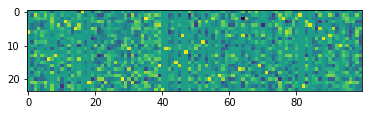

In [151]:
plt.imshow(Ptest)

## Precomputation

In [164]:
A = dft

# keys: [level][i, j]
Ps = [{} for i in range(nlevels+1)]
Bs = [{} for i in range(nlevels+1)] 

### Level 0

In [60]:
lev = Level(0, nlevels, n)

assert lev.nblock_rows == 1
for i in range(lev.nblock_rows):
    for j in range(lev.nblock_cols):
        b, p = Bs[0][i, j], Ps[0][i, j] = decomp(lev.matview(i, j, A))
        if (i, j) == (0, 0):
            print(f"B: {b.shape[0]}x{b.shape[1]} P: {p.shape[0]}x{p.shape[1]}")

B: 2048x4 P: 4x4


### Levels 1, ..., L

In [59]:
for ilev in range(1, nlevels + 1):
    lev = Level(ilev, nlevels, n)

    for j in range(lev.nblock_rows):
        for k in range(lev.nblock_cols):
            # only process even j
            if j % 2 != 0:
                continue
                
            bblock = np.hstack((
                Bs[ilev-1][j//2, 2*k],
                Bs[ilev-1][j//2, 2*k+1],
                ))
            bblock_top = bblock[:lev.block_nrows]
            bblock_bottom = bblock[lev.block_nrows:]
            assert len(bblock_top)*2 == len(bblock)
            
            Bs[ilev][j, k], Ps[ilev][j, k] = decomp(bblock_top)
            Bs[ilev][j+1, k], Ps[ilev][j+1, k] = decomp(bblock_bottom)

            if (j, k) == (0, 0):
                tB = Bs[ilev][j, k].shape
                tP = Ps[ilev][j, k].shape
                print(
                    f"Level {ilev}: {lev.block_nrows}x{lev.block_ncols} "
                    f"Btop: {bblock_top.shape[0]}x{bblock_top.shape[1]} -> B: {tB[0]}x{tB[1]} P: {tP[0]}x{tP[1]}")

Level 1: 1024x8 Btop: 1024x8 -> B: 1024x8 P: 8x8
Level 2: 512x16 Btop: 512x16 -> B: 512x16 P: 16x16
Level 3: 256x32 Btop: 256x32 -> B: 256x16 P: 16x32
Level 4: 128x64 Btop: 128x33 -> B: 128x17 P: 17x33
Level 5: 64x128 Btop: 64x34 -> B: 64x17 P: 17x34
Level 6: 32x256 Btop: 32x34 -> B: 32x17 P: 17x34
Level 7: 16x512 Btop: 16x34 -> B: 16x16 P: 16x34
Level 8: 8x1024 Btop: 8x32 -> B: 8x8 P: 8x32
Level 9: 4x2048 Btop: 4x16 -> B: 4x4 P: 4x16


Text(0, 0.5, 'Rank')

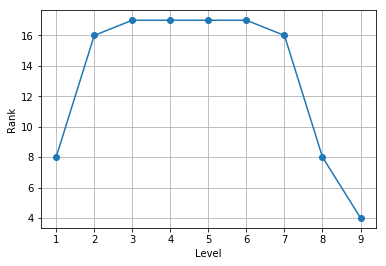

In [44]:
levels = []
ranks = []

for ilev in range(1, nlevels + 1):
    levels.append(ilev)
    ranks.append(Bs[ilev][0,0].shape[1])
    
plt.plot(levels, ranks, "o-")
plt.grid()
plt.xlabel("Level")
plt.ylabel("Rank")

Only the last-level $B$ actually needs to be retained:

In [169]:
LLB = Bs[-1]
del Bs

## Matvec

First, generate a random input:

In [170]:
x = np.random.randn(n)

### Setup

In [171]:
# keys: [ilevel][i, j]
betas = [{} for i in range(nlevels+1)]

### Level 0

In [172]:
lev = Level(0, nlevels, n)

assert lev.nblock_rows == 1
for i in range(lev.nblock_rows):
    for j in range(lev.nblock_cols):
        betas[0][i, j] = Ps[0][i, j] @ lev.colview(j, x)

### Level 1, ..., L

In [63]:
#clear
for ilev in range(1, nlevels + 1):
    lev = Level(ilev, nlevels, n)

    for j in range(lev.nblock_rows):
        for k in range(lev.nblock_cols):
            beta_glued = np.hstack((
                betas[ilev-1][j//2, 2*k],
                betas[ilev-1][j//2, 2*k+1]
                ))
            
            betas[ilev][j, k] = Ps[ilev][j, k] @ beta_glued
            if (j, k) == (0, 0):
                p = Ps[ilev][j, k]
                print(f"P: {p.shape[0]}x{p.shape[1]} * ({lev.nblock_rows}x{lev.nblock_cols} = {lev.nblock_rows*lev.nblock_cols})")

P: 8x8 * (2x256 = 512)
P: 16x16 * (4x128 = 512)
P: 16x32 * (8x64 = 512)
P: 17x33 * (16x32 = 512)
P: 17x34 * (32x16 = 512)
P: 17x34 * (64x8 = 512)
P: 16x34 * (128x4 = 512)
P: 8x32 * (256x2 = 512)
P: 4x16 * (512x1 = 512)


### Postprocess

In [174]:
Ax = np.zeros(n, dtype=np.complex128)

lev = Level(nlevels, nlevels, n)

assert lev.nblock_cols == 1
for j in range(lev.nblock_rows):
    for k in range(lev.nblock_cols):
        lev.rowview(j, Ax)[:] = LLB[j, k] @ betas[nlevels][j, k]

In [175]:
la.norm(Ax - A@x)/la.norm(A@x)

7.199035602677768e-11